In [ ]:
import ollama
import json
import lancedb
from lancedb.rerankers import ColbertReranker
from tqdm.notebook import tqdm
import numpy as np
import torch
from evaluate import load

METRICS_FIGURE_NAME = "Contextual retrieval performance metrics (Context prepended)"


TABLE_NAME = "my_anthropic_sliding_tobacco_table"
QNA_FILE_PATH = "q_and_a/tobacco_policy.json"

BENCHMARKING_OUTPUT_DIR = "benchmarking_results/tobacco"
BENCHMARKING_PREDICTIONS_FILE_NAME = "qa_predictions_anthropic_sliding_prepended.json"
BENCHMARKING_METRICS_FILE_NAME = "anthropic_sliding_metrics_barplot_prepended.png"

SYSTEM_PROMPT = """
You are a research assistant.  
Your role is to provide direct, concise, and accurate answers strictly based on the given context from studies, papers, or documents.  

Guidelines:  
- Only use information present in the provided context. Do not speculate or add outside knowledge.  
- Keep answers short, precise, and informative. Avoid unnecessary words, introductions, or conclusions.  
- When possible, answer in one to three sentences.  
- Maintain a formal, academic tone.  
- If the context does not contain the answer, respond with: "The answer is not available in the provided context."  

Your output should be optimized for evaluation with ROUGE, BLEU, and METEOR, focusing on clarity, correctness, and n-gram alignment with reference answers.
Answer only. Do not restate the question. Do not include phrases like "The answer is" or "In summary". Respond only with the content of the answer.
"""

In [ ]:
db = lancedb.connect("./db")
table = db.open_table(TABLE_NAME)
reranker = ColbertReranker()

with open(QNA_FILE_PATH, "r") as f:
    qna = json.load(f)

Loading ColBERTRanker model colbert-ir/colbertv2.0 (this message can be suppressed by setting verbose=0)
No device set
Using device cuda
No dtype set
Using dtype torch.float32
Loading model colbert-ir/colbertv2.0, this might take a while...
Linear Dim set to: 128 for downcasting


In [ ]:

reference_answers = []
predicted_answers = []

for question in tqdm(qna, desc="Processing questions..."):
        question_prompt = question["question"]
        reference_answers.append(question["gold_answer"])
        results = table.search(question_prompt, query_type="hybrid", vector_column_name="vector", fts_columns="text") \
                .rerank(reranker=reranker) \
                .limit(3) \
                .to_pandas()

        response = ollama.chat(
                model="gemma3:4b-it-qat",
                messages=[
                        {"role": "system", "content": SYSTEM_PROMPT},
                        {"role": "user", "content": f"QUESTION: {question_prompt}\n\nCONTEXT: {results.text.to_list()}"},
                ],
                options={
                        "temperature": 0.1,
                        "num_ctx": 16384
                        }
                        
        )

        response_text = response["message"]["content"].strip()
        predicted_answers.append(response_text)

with open(f"{BENCHMARKING_OUTPUT_DIR}/{BENCHMARKING_FILE_PATH}", "w") as f:
        json.dump({
                "reference_answers": reference_answers,
                "predicted_answers": predicted_answers
        }, f, indent=2)

Processing questions...:   0%|          | 0/131 [00:00<?, ?it/s]

<All keys matched successfully>


In [2]:

torch.cuda.empty_cache()

print("Loading evaluation metrics (ROUGE, METEOR, BLEU, BERTScore)...")
rouge = load("rouge")
meteor = load("meteor")
bleu = load("bleu")
bertscore = load("bertscore")
print("Metrics loaded successfully.")

Loading evaluation metrics (ROUGE, METEOR, BLEU, BERTScore)...


[nltk_data] Downloading package wordnet to /home/martin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/martin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/martin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Metrics loaded successfully.


In [ ]:
with open(f"{BENCHMARKING_OUTPUT_DIR}/{BENCHMARKING_FILE_PATH}", "r") as f:
    qa_predictions = json.load(f)

predicted_answers = qa_predictions["predicted_answers"]
reference_answers = qa_predictions["reference_answers"]

rouge_results = rouge.compute(
    predictions=predicted_answers,
    references=reference_answers
    )

meteor_results = meteor.compute(
    predictions=predicted_answers,
    references=reference_answers
    )

bleu_results = bleu.compute(
    predictions=predicted_answers,
    references=[[answer] for answer in reference_answers]  # BLEU expects a list of references per prediction
    )

bertscore_results = bertscore.compute(
    predictions=predicted_answers,
    references=reference_answers,
    model_type="microsoft/deberta-xlarge-mnli",
    batch_size=8,
    lang="en"
    )

np.mean(bertscore_results['f1'])

np.float64(0.7466665535937739)

/tmp/ipykernel_157533/2419929505.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x="Metric", y="Value", palette=cmap(list(np.linspace(0, 1, len(data)))))
/tmp/ipykernel_157533/2419929505.py:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(data=data, x="Metric", y="Value", palette=cmap(list(np.linspace(0, 1, len(data)))))


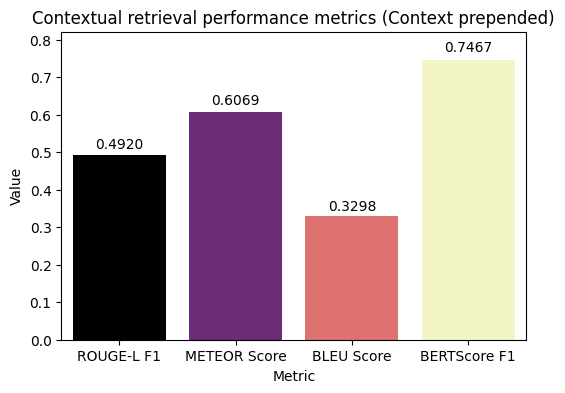

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example: three values with labels
data = pd.DataFrame({
    "Metric": ["ROUGE-L F1", "METEOR Score", "BLEU Score", "BERTScore F1"],
    "Value": [rouge_results['rougeLsum'], meteor_results['meteor'], bleu_results['bleu'], np.mean(bertscore_results['f1'])]
})
cmap = plt.get_cmap("magma")

plt.figure(figsize=(6,4))
ax = sns.barplot(data=data, x="Metric", y="Value", palette=cmap(list(np.linspace(0, 1, len(data)))))
ax.set_ylim(0, max(data["Value"]) * 1.1)

# Add annotations
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,   # x-position (center of bar)
        p.get_height()*1.02,            # y-position (just above bar)
        f"{p.get_height():.4f}",         # value label
        ha="center", va="bottom", fontsize=10
    )

plt.title(METRICS_FIGURE_NAME)
plt.savefig(f"{BENCHMARKING_OUTPUT_DIR}/{BENCHMARKING_METRICS_FILE_NAME}", dpi=300)

plt.show()



In [ ]:
# with open("tobacco_sliding_chunks_with_metadata.json", "r") as f:
#     chunks_with_metadata = json.load(f)

In [ ]:
# from lancedb.embeddings import get_registry
# from lancedb.pydantic import LanceModel, Vector
# import torch
# registry = get_registry()
# hf = registry.get("huggingface").create(name="nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device="cuda" if torch.cuda.is_available() else "cpu")


# # Define model
# class MyDocument(LanceModel):
#     text: str 
#     vector: Vector(hf.ndims()) = hf.VectorField()
#     original_text: str = hf.SourceField()
#     context: str
#     document: str
#     pages: list[int]  # Any additional metadata
#     id: str  # Unique identifier for the chunk

# db.create_table("my_traditional_tobacco_table", schema=MyDocument, mode="overwrite") # Uncommend this line when running this cell for the first time
# table = db.open_table("my_traditional_tobacco_table")

# # Upload in batches with progress bar
# batch_size = 100
# for i in tqdm(range(0, len(chunks_with_metadata), batch_size), desc="Uploading chunks to VectorDB"):
#     batch = chunks_with_metadata[i:i+batch_size]
#     table.add(batch)

# table.create_scalar_index("id", replace=True) # Index based on the chunk's id, used to manually prevent duplicates

# reranker = ColbertReranker()
# table.create_fts_index("text", replace=True) # Used by the reranker as well as the hybrid search's BM25 index
# table.wait_for_index(["text_idx"])  # Wait for the indexing to finish

<All keys matched successfully>


Uploading chunks to VectorDB:   0%|          | 0/2 [00:00<?, ?it/s]

<All keys matched successfully>
<All keys matched successfully>


Loading ColBERTRanker model colbert-ir/colbertv2.0 (this message can be suppressed by setting verbose=0)
No device set
Using device cuda
No dtype set
Using dtype torch.float32
Loading model colbert-ir/colbertv2.0, this might take a while...
Linear Dim set to: 128 for downcasting
